# Transfer Learning with MobileNetV2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


2024-09-10 20:03:51.817495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='1-1'></a>
### 1.1 Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

You'll also set your seeds to match each other, so your training and validation sets don't overlap. :) 

In [2]:
Batch_size = 32
Image_size = (160,160)
directory = 'dataset/'

train_dataset = image_dataset_from_directory(directory,
                                                batch_size = Batch_size,
                                                image_size = Image_size,
                                                shuffle = True,
                                                validation_split = 0.2,
                                                subset = 'training',
                                                seed = 42)

validation_dataset = image_dataset_from_directory(directory,
                                                  batch_size = Batch_size,
                                                  image_size = Image_size,
                                                  shuffle = True,
                                                  validation_split = 0.2,
                                                  subset = 'validation',
                                                  seed = 42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


2024-09-10 20:03:54.560656: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2024-09-10 20:03:54.867988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [262]
	 [[{{node Placeholder/_4}}]]
2024-09-10 20:03:54.868434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [262]
	 [[{{node Placeholder/_4}}]]


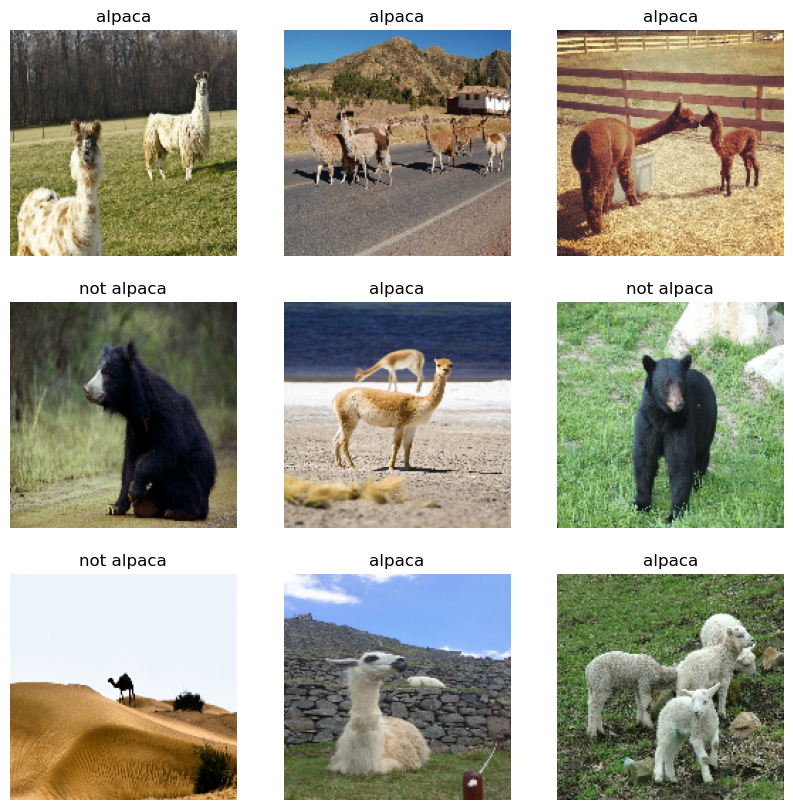

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data

You may have encountered `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augumentation = tf.keras.Sequential()
    data_augumentation.add(RandomFlip('horizontal'))
    data_augumentation.add(RandomRotation(0.2))

    return data_augumentation

2024-09-10 20:03:59.286897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [262]
	 [[{{node Placeholder/_4}}]]
2024-09-10 20:03:59.287714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [262]
	 [[{{node Placeholder/_4}}]]


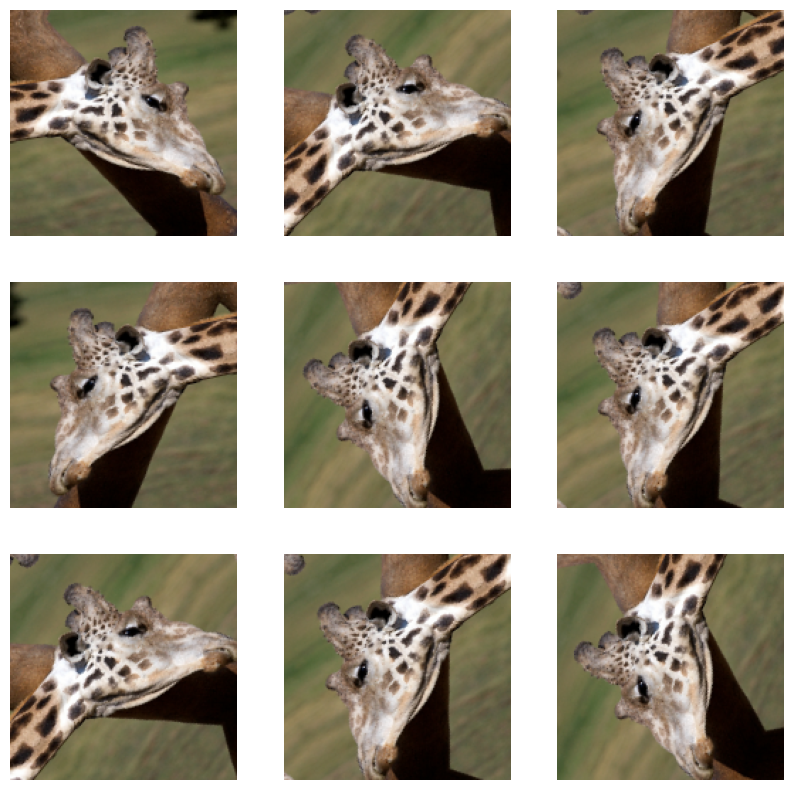

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
IMG_SHAPE = Image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [11]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-09-10 20:05:55.668514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [262]
	 [[{{node Placeholder/_0}}]]
2024-09-10 20:05:55.669177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [262]
	 [[{{node Placeholder/_4}}]]


(32, 1000)


In [13]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [14]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 1us/step


[[('n04589890', 'window_screen', 0.42582187),
  ('n02708093', 'analog_clock', 0.0927559)],
 [('n04589890', 'window_screen', 0.23985897),
  ('n03887697', 'paper_towel', 0.14802587)],
 [('n04589890', 'window_screen', 0.7449457),
  ('n03598930', 'jigsaw_puzzle', 0.021948649)],
 [('n04589890', 'window_screen', 0.3354607),
  ('n03530642', 'honeycomb', 0.07628939)],
 [('n04589890', 'window_screen', 0.27327394),
  ('n03733281', 'maze', 0.08846915)],
 [('n04589890', 'window_screen', 0.6745247),
  ('n03530642', 'honeycomb', 0.07659865)],
 [('n04589890', 'window_screen', 0.79128367),
  ('n04209239', 'shower_curtain', 0.09241717)],
 [('n04589890', 'window_screen', 0.16463035),
  ('n03598930', 'jigsaw_puzzle', 0.08749191)],
 [('n03598930', 'jigsaw_puzzle', 0.37021348),
  ('n04589890', 'window_screen', 0.099570066)],
 [('n04589890', 'window_screen', 0.6161666),
  ('n03887697', 'paper_towel', 0.0548766)],
 [('n03530642', 'honeycomb', 0.2544884),
  ('n04589890', 'window_screen', 0.24874473)],
 [('n04

In [17]:
def alpaca_model(image_shape=Image_size, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''

    
    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    # Freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    # Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
        
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [18]:
model2 = alpaca_model(Image_size, data_augmentation)

9406464/9406464 [==============================] - 2s 0us/step


In [20]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.6031

2024-09-10 20:16:09.863050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [65]
	 [[{{node Placeholder/_4}}]]
2024-09-10 20:16:09.863720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [65]
	 [[{{node Placeholder/_4}}]]


9/9 [==============================] - 20s 2s/step - loss: 0.7236 - accuracy: 0.6031 - val_loss: 0.5038 - val_accuracy: 0.6615
Epoch 2/5
9/9 [==============================] - 14s 2s/step - loss: 0.5381 - accuracy: 0.6794 - val_loss: 0.4348 - val_accuracy: 0.6923
Epoch 3/5
9/9 [==============================] - 16s 2s/step - loss: 0.4701 - accuracy: 0.7824 - val_loss: 0.3507 - val_accuracy: 0.7692
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.7519

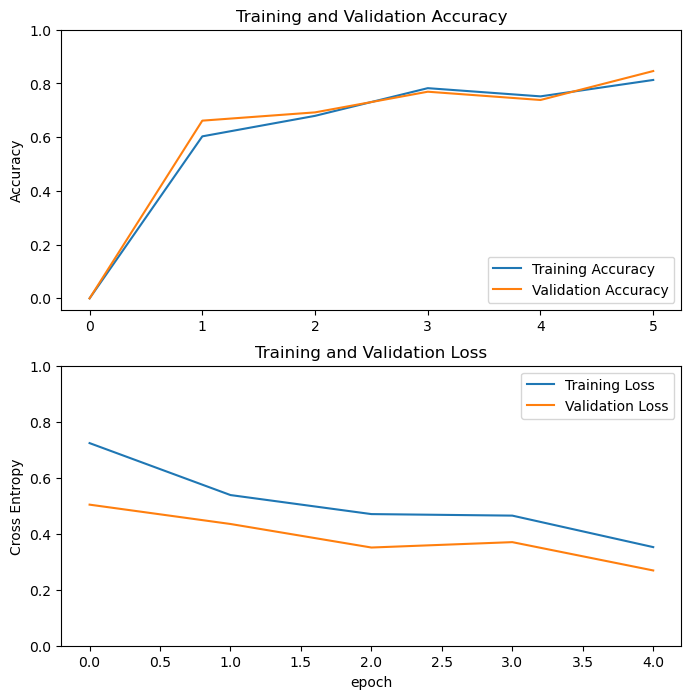

In [21]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
class_names

['alpaca', 'not alpaca']

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [24]:
# UNQ_C3

base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 126

### START CODE HERE

##### One Way ########
"""
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
"""
######## Other Way ######
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [26]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 18s 2s/step - loss: 0.3752 - accuracy: 0.8168 - val_loss: 0.2458 - val_accuracy: 0.8462
Epoch 6/10
9/9 [==============================] - 15s 2s/step - loss: 0.3694 - accuracy: 0.8168 - val_loss: 0.2091 - val_accuracy: 0.8923
Epoch 7/10
9/9 [==============================] - 19s 2s/step - loss: 0.3590 - accuracy: 0.8282 - val_loss: 0.1892 - val_accuracy: 0.9231
Epoch 8/10
9/9 [==============================] - 16s 2s/step - loss: 0.3321 - accuracy: 0.8397 - val_loss: 0.1934 - val_accuracy: 0.9077
Epoch 9/10
9/9 [==============================] - 15s 2s/step - loss: 0.2530 - accuracy: 0.8931 - val_loss: 0.1679 - val_accuracy: 0.9231
Epoch 10/10
9/9 [==============================] - 16s 2s/step - loss: 0.2877 - accuracy: 0.8817 - val_loss: 0.1498 - val_accuracy: 0.9231


In [24]:


base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 126

### START CODE HERE

##### One Way ########
"""
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
"""
######## Other Way ######
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156
